# Code for Section 3.3 Computing Simulated Risk Factors
This example shows how to compute the risk factor simulation using the simulated stationary transformations from Section 3.2.1.

The first part is the same as the accompanying code for Section 3.2.1 to avoid storing a three-dimensional matrix, but we avoid simulating conditional on different states. We just use the latest as the initial state.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import fortitudo.tech as ft
import matplotlib.pyplot as plt

In [2]:
# Load the time series data and extract 1m ATMF implied vol state variable
time_series = ft.load_time_series()  # to extract the 1m implied vol series used as a state variable
st_df = pd.read_csv('st_df.csv', index_col=0)  # to avoid recomputing the stationary transformations from 3.1
imp_vol_1m = time_series['1m100'].iloc[1:].values

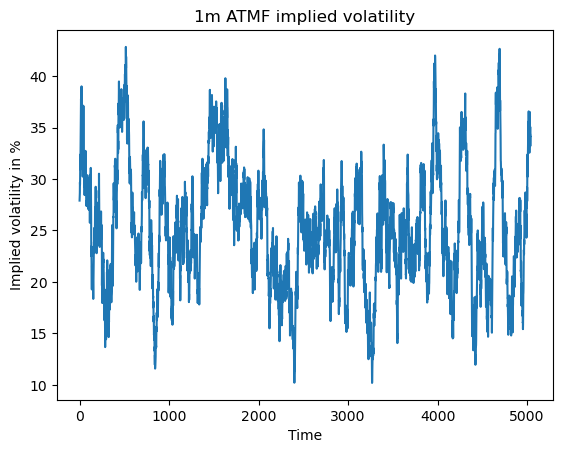

In [3]:
plt.plot(imp_vol_1m)
plt.title('1m ATMF implied volatility')
plt.ylabel('Implied volatility in %')
plt.xlabel('Time')
plt.show()

In [4]:
# Compute percentiles and indices
imp_vol_25pct = np.percentile(imp_vol_1m, 25)
low_vol_indices = imp_vol_1m <= imp_vol_25pct
imp_vol_75pct = np.percentile(imp_vol_1m, 75)
mid_vol_indices = (imp_vol_1m < imp_vol_25pct) ^ (imp_vol_1m <= imp_vol_75pct)
high_vol_indices = imp_vol_1m > imp_vol_75pct

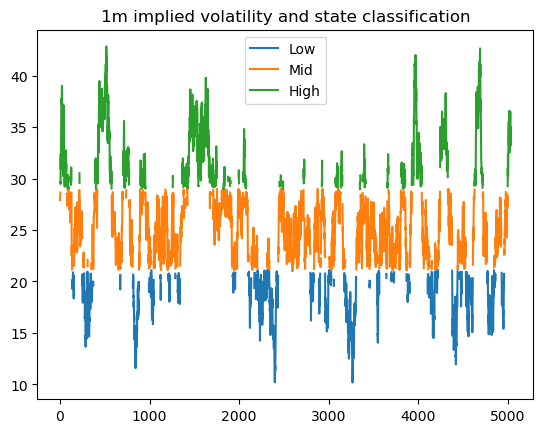

In [5]:
# Plot the 1m implied vol with state classification
vol_low = np.ma.masked_where(low_vol_indices == False, imp_vol_1m)
vol_mid = np.ma.masked_where(mid_vol_indices == False, imp_vol_1m)
vol_high = np.ma.masked_where(high_vol_indices == False, imp_vol_1m)
x = np.arange(0, len(imp_vol_1m))
plt.plot(x, vol_low, x, vol_mid, x, vol_high)
plt.legend(['Low', 'Mid', 'High'])
plt.title('1m implied volatility and state classification')
plt.show()

# Compute scenario probabilities for Fully Flexible Resampling

In [6]:
# Exponential decay prior
T_tilde = len(st_df)
p_exp = ft.exp_decay_probs(st_df, half_life=T_tilde / 2)

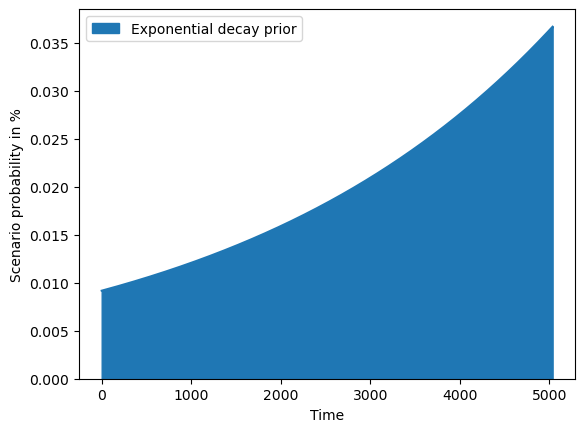

In [7]:
pd.DataFrame(100 * p_exp, columns=['Exponential decay prior']).plot(kind='area')
plt.ylabel('Scenario probability in %')
plt.xlabel('Time')
plt.show()

In [8]:
# Compute view values for Entropy Pooling views
mu_low = np.mean(imp_vol_1m[low_vol_indices])
sigma_low = np.std(imp_vol_1m[low_vol_indices])
mu_mid = np.mean(imp_vol_1m[mid_vol_indices])
sigma_mid = np.std(imp_vol_1m[mid_vol_indices])
mu_high = np.mean(imp_vol_1m[high_vol_indices])
sigma_high = np.std(imp_vol_1m[high_vol_indices])

In [9]:
# Specify left hand sides for Entropy Pooling views
A = np.vstack((np.ones((1, T_tilde)), imp_vol_1m))  # probabilities sum to 1 and mean
b_low = np.array(([[1.], [mu_low]]))
b_mid = np.array(([[1.], [mu_mid]]))
b_high = np.array(([[1.], [mu_high]]))
G = imp_vol_1m[:, np.newaxis].T ** 2
h_low = np.array([[sigma_low ** 2 + mu_low ** 2]])
h_mid = np.array([[sigma_mid ** 2 + mu_mid ** 2]])
h_high = np.array([[sigma_high ** 2 + mu_high ** 2]])

In [10]:
# Compute Fully Flexible Resampling probability vectors
q_low = ft.entropy_pooling(p_exp, A, b_low, G, h_low)
q_mid = ft.entropy_pooling(p_exp, A, b_mid, G, h_mid)
q_high = ft.entropy_pooling(p_exp, A, b_high, G, h_high)

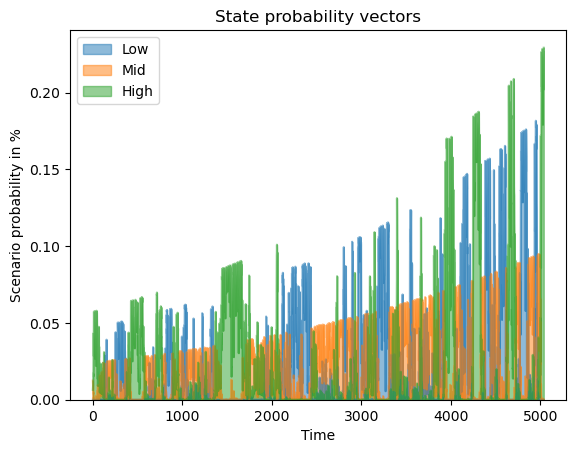

In [11]:
states_prob = np.hstack((q_low / np.sum(q_low), q_mid / np.sum(q_mid), q_high / np.sum(q_high)))
pd.DataFrame(100 * states_prob, columns=['Low', 'Mid', 'High']).plot(kind='area', stacked=False)
plt.title('State probability vectors')
plt.xlabel('Time')
plt.ylabel('Scenario probability in %')
plt.show()

# Simulate

In [12]:
states_vector = 0 * low_vol_indices + 1 * mid_vol_indices + 2 * high_vol_indices

In [13]:
# Define a Fully Flexible Resampling function
def resampling(S, H, initial_state, states_prob, states_vector):
    sim = np.full((S, H), 1)
    t = np.arange(len(states_vector))
    for s in range(S):
        current_state = initial_state
        for h in range(H):
            sim[s, h] = np.random.choice(t, p=states_prob[:, current_state])
            current_state = states_vector[sim[s, h]]
    return sim

In [14]:
# Simulate historical observations
S = 10000
H = 21
np.random.seed(0)
sim = resampling(S, H, states_vector[-1], states_prob, states_vector)

# Compute simulated risk factors

In [15]:
# Extract stationary transformations and compute cumulative sums
N_tilde = st_df.shape[1]
st_sim = np.full((S, N_tilde, H), np.nan)

for s in range(S):
    st_sim[s, :, :] = st_df.values[sim[s, :], :].T

st_sim_cumsum = np.cumsum(st_sim, axis=2)

In [16]:
print(f'The stationary transformations simulation dimension is {st_sim.shape}')

The stationary transformations simulation dimension is (10000, 79, 21)


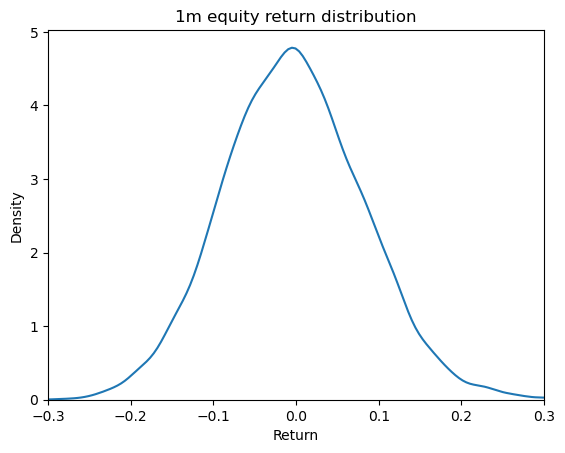

In [17]:
# Equity returns
equity_returns = np.exp(st_sim_cumsum[:, 0, -1]) - 1
sns.kdeplot(equity_returns)
plt.title('1m equity return distribution')
plt.xlabel('Return')
plt.xlim([-0.3, 0.3])
plt.show()

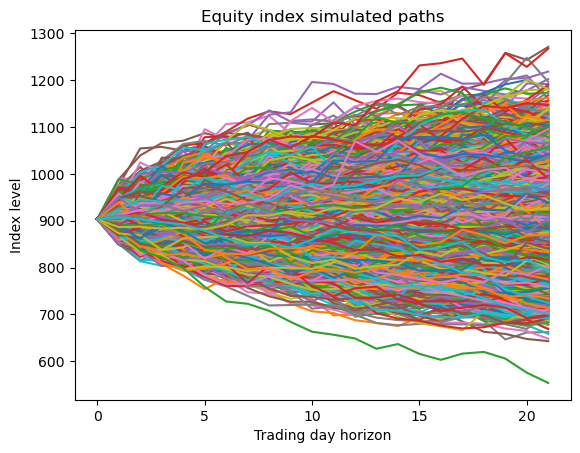

In [18]:
# Equity paths
init_vals = time_series.values[-1, :]
equity_paths = np.concatenate((np.full((S, 1), init_vals[0]),
                               np.exp(st_sim_cumsum[:, 0, :]) * init_vals[0]), axis=1)
plt.plot(equity_paths.T)
plt.title('Equity index simulated paths')
plt.ylabel('Index level')
plt.xlabel('Trading day horizon')
plt.show()

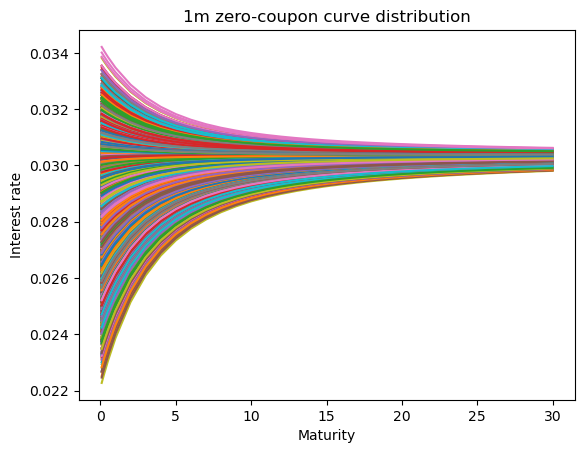

In [19]:
# Zero-coupon interest rates
maturities = np.hstack((np.array([1/12, 3/12, 6/12]), np.arange(1, 31)))
discount_factors_init = np.exp(-maturities * init_vals[1:34] / 100)
discount_factors_sim = discount_factors_init * np.exp(st_sim_cumsum[:, 1:34, -1])
interest_rates_sim = -np.log(discount_factors_sim) / maturities
plt.plot(maturities, interest_rates_sim.T)
plt.title('1m zero-coupon curve distribution')
plt.xlabel('Maturity')
plt.ylabel('Interest rate')
plt.show()

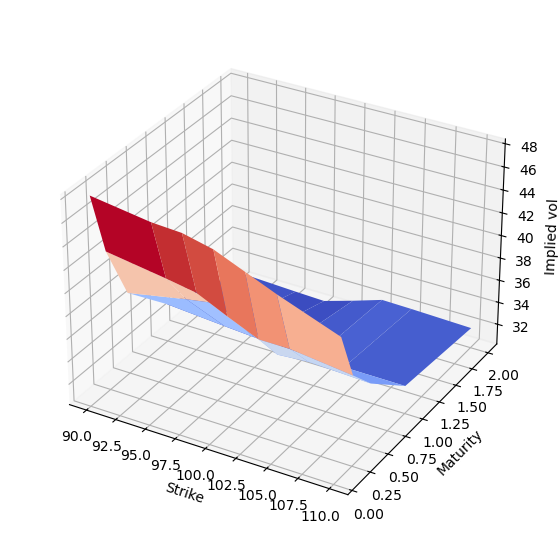

In [20]:
# Implied volatility surfaces
imp_vol_sim = init_vals[34:69] * np.exp(st_sim_cumsum[:, 34:69, -1])
ft.plot_vol_surface(1, imp_vol_sim, zoom=0.92)
plt.show()

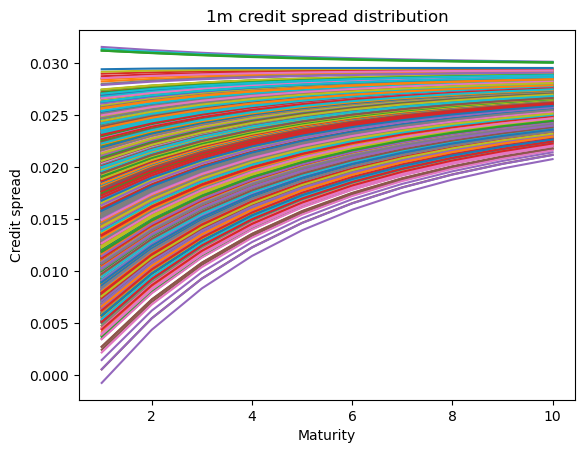

In [21]:
# Credit spreads
maturities_cr = np.arange(1, 11)
discount_factors_cr_init = np.exp(-maturities_cr * init_vals[69:] / 100)
discount_factors_cr_sim = discount_factors_cr_init * np.exp(st_sim_cumsum[:, 69:, -1])
credit_spread_sim = -np.log(discount_factors_cr_sim) / maturities_cr
plt.plot(maturities_cr, credit_spread_sim.T)
plt.title('1m credit spread distribution')
plt.xlabel('Maturity')
plt.ylabel('Credit spread')
plt.show()

In [22]:
# Save entire stationary transformation paths for Section 4.4 case study
columns = [0, 1, 37]
print(f'stationary transformations paths stored for {list(time_series.columns[columns])}.')
np.save('st_sim_cumsum', st_sim_cumsum[:, columns, :])

stationary transformations paths stored for ['Equity Index', '1m', '1m100'].


In [23]:
# Save risk factor simulation for Section 4.6 case study
risk_factor_sim = np.hstack((
    equity_returns[:, np.newaxis], interest_rates_sim, imp_vol_sim, credit_spread_sim))
print(f'Risk factor simulation shape is {risk_factor_sim.shape}. Should be (S={S}, I={time_series.shape[1]}).')

risk_factor_sim_pd = pd.DataFrame(risk_factor_sim, columns=time_series.columns)
risk_factor_sim_pd.to_csv('rf_sim.csv', index=False)

Risk factor simulation shape is (10000, 79). Should be (S=10000, I=79).


In [24]:
# pcrm-book - Next generation investment analysis.
# Copyright (C) 2025 Anton Vorobets.

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.